# **Alternative Splicing  Heatplot**
This notebook generates a heat plot representing sex-biased differential gene expression as well as a plot showing the counts of differentially expressed genes per tissue.

The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

The assumptions made before rendering the heatmaps 
1. Get differential gene expression (DGE) files
2. Use the ``../assets/tissues.tsv`` to limit the tissues to those with at least 50 samples in each sex (``tissues.tsv`` was produced by a Python script)
3. Use the pattern for the differentially expressed genes **"../data/*_AS_model_B_sex_as_events.csv"** to get all the values for the matrix.

## **Running this notebook**:

See the README for setting up prerequisites for the notebook.

## 1. Setup 

Assumes the `countGenesAndEvents.ipynb` notebook was run -- unpacking the results from the differential Gene Expression Analysis as run in the `differentialAlternativeSplicingJunctionAnalysis.ipynb` notebook.

In [1]:
suppressMessages({
    options(warn = -1) 
    library(stringr)
    library(edgeR)
    library(pheatmap)
    library(dplyr)
    library(ggplot2)
    library(scales)
    library(viridis)
    library(magrittr)
    library(ComplexHeatmap)
    library(circlize)
    library(snakecase)
    library(pvclust)
    library(devtools)
    library(data.table)
    Sys.setenv(TAR = "/bin/tar") # for gzfile
})

## 2. Making the matrices

### 2.1 Read in all the alternative Splicing Junction Analysis results

Start with the Skipped Exon alternative Splicing Junction Analysis results

In [2]:
results_dir <- "../data/"
pattern     <- "*_AS_model_B_sex_as_events_refined.csv"
files       <- list.files(path = results_dir, pattern = pattern)
message("Number of se AS files found with *AS_model_B_sex_as_events_refined.csv pattern: ",
        length(files))
se_files <- files[grepl("^se_", files)]
length(se_files)

Number of se AS files found with *AS_model_B_sex_as_events_refined.csv pattern: 195



[1] 39

### 2.2 read in the curated "../assets/tissues.tsv" 

The **`../assets/tissues.tsv`** file contains an indication to include the tissue if the file has at least **50** samples in that tissue with either **male** or **female** sex reporting

In [3]:
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))
# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

message("Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)",
        paste(dim(tissue_reduction), collapse=" "))


 0  1 
11 39 

Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)39 5



### 2.3 model rownames from fromGTF files

Arbitrarily using the first file, to obtain the ordered rownames for assignment to the remainder of the files in the construction of the matrix.

In [4]:
a3ss_annot <- read.table(file = "../data/fromGTF.A3SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
a5ss_annot <- read.table(file = "../data/fromGTF.A5SS.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
mxe_annot <- read.table(file = "../data/fromGTF.MXE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
ri_annot <- read.table(file = "../data/fromGTF.RI.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)
se_annot <- read.table(file = "../data/fromGTF.SE.txt", sep = "\t", quote = "\"", header = T, stringsAsFactors = F)

### 2.4 make a new column combining idx with geneSymbol

all of the model_B toptable events are annotated with **geneSymbol-alternativeSplicingEventID**.  These are alternative Splicing Event specific.   So we will have a matrix per alternative splicing event.

In [5]:
a3ss_annot$geneASID <- as.character(paste(a3ss_annot$geneSymbol, a3ss_annot$ID, sep="-"))
a5ss_annot$geneASID <- as.character(paste(a5ss_annot$geneSymbol, a5ss_annot$ID, sep="-"))
mxe_annot$geneASID  <- as.character(paste(mxe_annot$geneSymbol,  mxe_annot$ID, sep="-"))
ri_annot$geneASID   <- as.character(paste(ri_annot$geneSymbol,   ri_annot$ID, sep="-"))
se_annot$geneASID   <- as.character(paste(se_annot$geneSymbol,   se_annot$ID, sep="-"))


### 2.5 Heatmap gene-junction ids are union of events from all tissues

Junctions were removed for statistical requirements -- there are not the same number of results for all of the tissues.  As such we need to build the union of all the ids, order this and use this to enable making all of the matrices.

In [6]:
for (i in 1:length(se_files)) {
    fullfilename  <- paste0("../data/",se_files[i])
    logFC_result  <- read.csv(fullfilename)
    filegenesids  <- as.character(rownames(logFC_result))
    if (i == 1) {
        genesids <- filegenesids
    }
    genesids      <- union(as.character(genesids),filegenesids)
}
length(se_files)
idx <- str_order(genesids)
genesids <- genesids[idx]
length(genesids)
head(genesids)

[1] 39

[1] 2755

[1] "ABCA10-25861" "ABCA10-25867" "ABCA2-3039"   "ABCA7-17083"  "ABCA7-17084" 
[6] "ABCB11-1047"

### 2.7 With the union of gene-junction ids make a matrix of logFC and adjusted pValue data

In [7]:
files <- se_files
logFC_mat <- matrix(0.0, nrow=length(genesids), ncol = length(files))
pVal_mat  <- logFC_mat
    fullfilename  <- paste0("../data/",files[i])
    logFC_result  <- read.csv(fullfilename)
    filegenesids  <- as.character(rownames(logFC_result))

    for (j in 1:length(filegenesids)) {
        genesids_match <- genesids %in% filegenesids[j]
        logFC_mat[genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"logFC"]
        pVal_mat [genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"adj.P.Val"]
    }


In [8]:
files <- se_files
logFC_mat <- matrix(0.0, nrow=length(genesids), ncol = length(files))
pVal_mat  <- logFC_mat
rownames(logFC_mat) <- as.character(genesids)
for (i in 1:length(files)) {
    fullfilename  <- paste0("../data/",files[i])
    logFC_result  <- read.csv(fullfilename)
    filegenesids  <- as.character(rownames(logFC_result))
    # match the filegenesids in the list of unioned genesids for placing the significant gene-junction values
    # in the matrix where rows are gene-junctions and columns are tissues (filegenesids)
    for (j in 1:length(filegenesids)) {
        genesids_match <- genesids %in% filegenesids[j]
        logFC_mat[genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"logFC"]
        pVal_mat [genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"adj.P.Val"]
    }
}

mat_colnames = files
for (i in 1:length(mat_colnames)) {
    mat_colnames[i] <- gsub(pattern,"", mat_colnames[i], fixed = TRUE)
    mat_colnames[i] <- substring(mat_colnames[i],4)
}

display_name = ifelse(mat_colnames == tissue_reduction$SMTSD, 
                                      tissue_reduction$display_name,
                                      mat_colnames)
colnames(logFC_mat) <- as.character(display_name)
colnames(pVal_mat)  <- as.character(display_name)

ABCA10-25861 ABCA10-25867   ABCA2-3039  ABCA7-17083  ABCA7-17084  ABCB11-1047 
   0.7403387    0.6202246    0.6188782    0.6804410    0.6420282    0.8403343

[1] 2755

[1] "XIST-10149" "XIST-10150" "XIST-10151" "XIST-10152" "XIST-10154"
[6] "XIST-10155"

,adipose_subcutaneous_AS_model_B_sex_as_events_refined.csv,adipose_visceral_omentum_AS_model_B_sex_as_events_refined.csv,adrenal_gland_AS_model_B_sex_as_events_refined.csv,artery_aorta_AS_model_B_sex_as_events_refined.csv,artery_coronary_AS_model_B_sex_as_events_refined.csv,artery_tibial_AS_model_B_sex_as_events_refined.csv,brain_caudate_basal_ganglia_AS_model_B_sex_as_events_refined.csv,brain_cerebellar_hemisphere_AS_model_B_sex_as_events_refined.csv,brain_cerebellum_AS_model_B_sex_as_events_refined.csv,brain_cortex_AS_model_B_sex_as_events_refined.csv,⋯,nerve_tibial_AS_model_B_sex_as_events_refined.csv,pancreas_AS_model_B_sex_as_events_refined.csv,pituitary_AS_model_B_sex_as_events_refined.csv,skin_not_sun_exposed_suprapubic_AS_model_B_sex_as_events_refined.csv,skin_sun_exposed_lower_leg_AS_model_B_sex_as_events_refined.csv,small_intestine_terminal_ileum_AS_model_B_sex_as_events_refined.csv,spleen_AS_model_B_sex_as_events_refined.csv,stomach_AS_model_B_sex_as_events_refined.csv,thyroid_AS_model_B_sex_as_events_refined.csv,whole_blood_AS_model_B_sex_as_events_refined.csv
XIST-10149,-7.207514,-7.232707,0.000000,-7.217785,-6.651604,-7.306580,-7.136902,-8.018341,-7.831804,-7.192355,⋯,-3.070226,-7.655221,-7.230445,-7.146028,-6.941428,-6.834630,0.000000,-6.648115,-7.451470,0.000000
XIST-10150,-3.041437,0.000000,0.000000,0.000000,-2.556596,0.000000,-3.882131,-3.912647,0.000000,0.000000,⋯,0.000000,0.000000,-3.247772,-2.846555,-2.862227,-2.667588,0.000000,-2.434961,-2.670720,0.000000
XIST-10151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.000000,0.000000,-1.338761,-1.540295,0.000000,-1.258413,0.000000,-1.236821,0.000000,0.000000
XIST-10152,6.142582,6.668817,6.861573,6.236745,5.883898,6.371806,5.913729,6.353142,6.191022,5.628328,⋯,2.450193,6.632995,5.588178,6.275677,6.194104,5.714471,6.900901,5.466854,6.220776,4.838214
XIST-10154,-6.955680,0.000000,0.000000,0.000000,-6.420964,0.000000,-6.858995,0.000000,0.000000,-6.701411,⋯,-3.062198,0.000000,0.000000,0.000000,-6.679510,-6.511821,0.000000,-6.367163,-7.109773,0.000000
XIST-10155,0.000000,0.000000,0.000000,0.000000,-1.334014,0.000000,-1.782809,0.000000,0.000000,0.000000,⋯,0.000000,0.000000,-1.957347,-1.653003,0.000000,-1.733439,0.000000,-1.472781,0.000000,0.000000


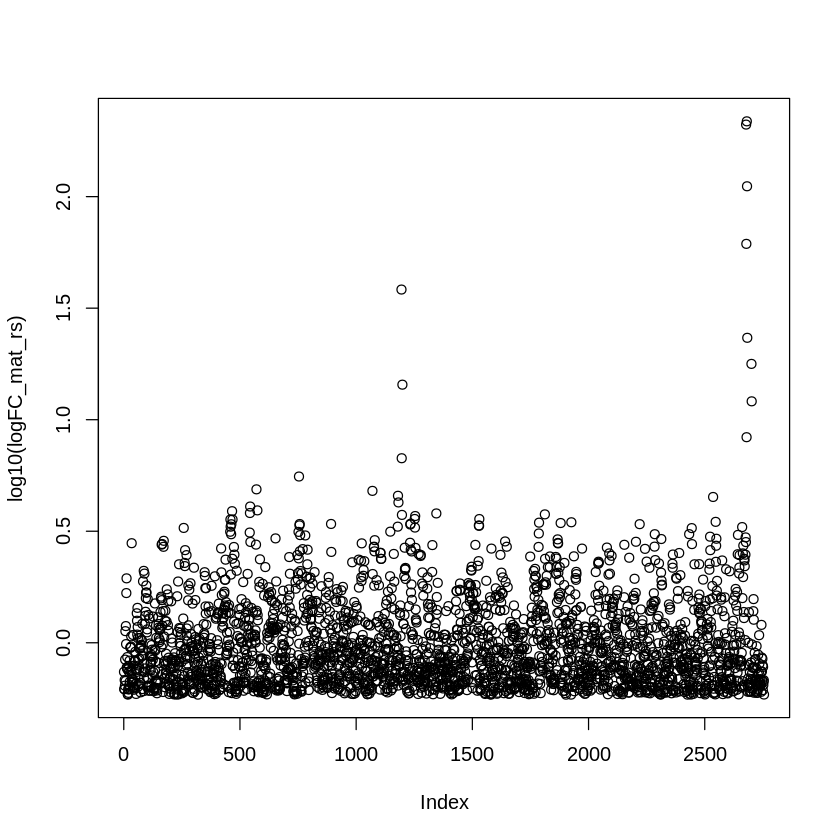

In [9]:
logFC_mat_rs <- rowSums(abs(logFC_mat))
names(logFC_mat_rs) <- as.character(rownames(logFC_mat))
head(logFC_mat_rs)
plot(log10(logFC_mat_rs))
length(names(logFC_mat_rs))
names(logFC_mat_rs[2678:2683])
logFC_mat[2678:2683,]

# 2.9 generate a heatmap using agglomeration methods by Ward and distance metric by Minkowski by tissues

In [10]:
colnames(logFC_mat) <- as.character(tissue_reduction$display)

In [11]:
logFC_mat_pv <- pvclust(logFC_mat, method.hclust="ward.D2", method.dist="minkowski", nboot = 1000)

Bootstrap (r = 0.5)... Done.
Bootstrap (r = 0.6)... Done.
Bootstrap (r = 0.7)... Done.
Bootstrap (r = 0.8)... Done.
Bootstrap (r = 0.9)... Done.
Bootstrap (r = 1.0)... Done.
Bootstrap (r = 1.1)... Done.
Bootstrap (r = 1.2)... Done.
Bootstrap (r = 1.3)... Done.
Bootstrap (r = 1.4)... Done.


png 
  2

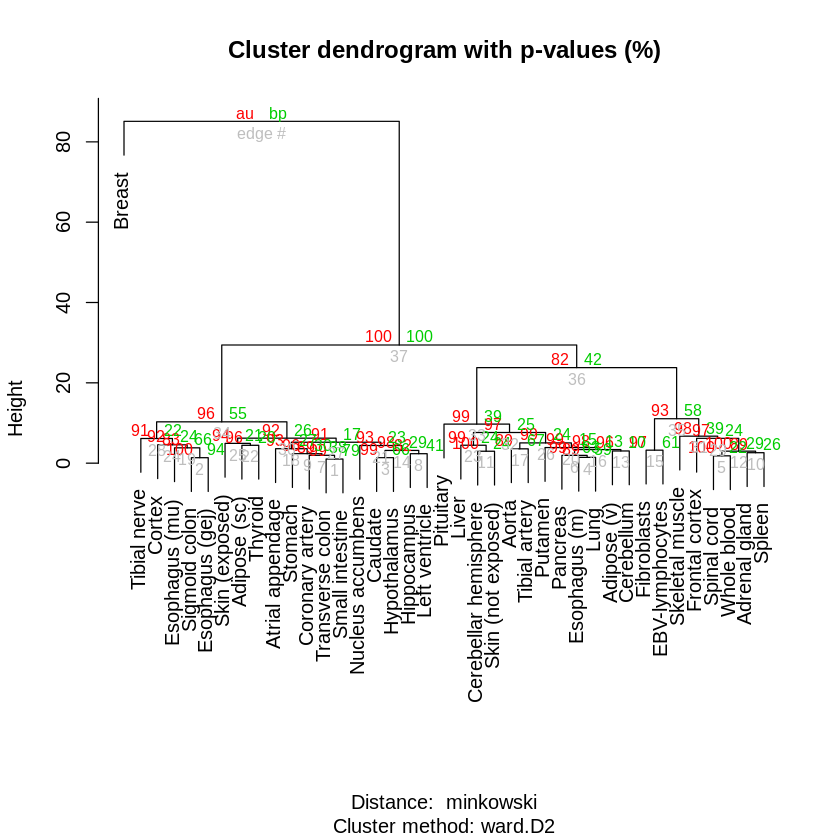

In [12]:
plot(logFC_mat_pv)
pdf("../pdf/logFC_mat_pvclust_ward_minkowski.pdf")
plot(logFC_mat_pv)
dev.off()

## the fold change is the qualifying event, but a matrix can be shown of the the junction expression values 

Using the function from the differentialSplicingJunctionAnalysis.ipynb make a counts matrix of the IJC and SJC matrices and show the heatmap of their results

In [13]:
makeCountsMatrix <- function (filename_gz) {
    message("\nloading ", paste(filename_gz), collapse=" ")
    counts <- data.table::fread(filename_gz)
    message("done!")
    rownames(counts) <- counts$ID
    counts <- counts[,-1]
    counts <- data.matrix(counts)
    return(counts)
}

ijc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.se.jc.ijc.txt.gz")
sjc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.se.jc.sjc.txt.gz")




loading ../data/rmats_final.se.jc.ijc.txt.gz 

done!


loading ../data/rmats_final.se.jc.sjc.txt.gz 

done!



In [ ]:
logFC_mat[1:10,1:10]

### 2.10 Calculate the correlation between the tissues using the logFC

Calculate the correlation distances between the tissues using the logFC within each of the tissues.   Clustering by similar expression.

In [14]:
#logFC_mat_NQ <- normalizeQuantiles(logFC_mat)
dist.mat<-as.matrix(cor(logFC_mat))
colnames(dist.mat) <- as.character(tissue_reduction$display)
rownames(dist.mat) <- as.character(tissue_reduction$display)
desc(dist.mat)

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
Adipose (sc),-1.00000000,-0.73489891,-0.4808458,-0.72611009,-0.95462484,-0.74711472,-0.9440866328,-7.889360e-01,-7.464707e-01,-0.9211626840,⋯,-8.922565e-01,-0.74093776,-0.6512776418,-0.77210988,-9.271591e-01,-0.94413369,-0.4839399008,-0.94242994,-0.93913158,-0.4969486066
Adipose (v),-0.73489891,-1.00000000,-0.6510429,-0.91133836,-0.76908822,-0.92710476,-0.7248911059,-9.019988e-01,-9.560030e-01,-0.7701682259,⋯,-7.387933e-01,-0.95371149,-0.7505387327,-0.90348308,-7.317517e-01,-0.75128829,-0.6451415984,-0.75043700,-0.74638505,-0.6632991770
Adrenal gland,-0.48084582,-0.65104291,-1.0000000,-0.61723523,-0.51644197,-0.62259598,-0.4535699567,-5.602494e-01,-5.910532e-01,-0.4662803970,⋯,-4.698395e-01,-0.64683996,-0.4564940725,-0.59612466,-4.820239e-01,-0.49390857,-0.9362469181,-0.49397118,-0.48113915,-0.9490171953
Aorta,-0.72611009,-0.91133836,-0.6172352,-1.00000000,-0.73977472,-0.94072657,-0.6936398009,-8.670172e-01,-9.183686e-01,-0.7376668177,⋯,-7.129141e-01,-0.93306336,-0.7208738921,-0.87063263,-7.011600e-01,-0.72810165,-0.6077517234,-0.72594044,-0.72031346,-0.6154060315
Coronary artery,-0.95462484,-0.76908822,-0.5164420,-0.73977472,-1.00000000,-0.75290565,-0.9797314243,-8.103110e-01,-7.748309e-01,-0.9467615373,⋯,-9.241570e-01,-0.77144637,-0.6873241329,-0.80956220,-9.416154e-01,-0.98749653,-0.5150097145,-0.98076575,-0.96138816,-0.5284341130
Tibial artery,-0.74711472,-0.92710476,-0.6225960,-0.94072657,-0.75290565,-1.00000000,-0.7053900478,-8.840987e-01,-9.358965e-01,-0.7499683102,⋯,-7.294174e-01,-0.93578218,-0.7339202286,-0.88660982,-7.144491e-01,-0.74141696,-0.6144998496,-0.73526576,-0.73407447,-0.6310498759
Caudate,-0.94408663,-0.72489111,-0.4535700,-0.69363980,-0.97973142,-0.70539005,-1.0000000000,-8.000472e-01,-7.343959e-01,-0.9329933000,⋯,-8.647395e-01,-0.73167155,-0.6901356700,-0.80676558,-9.345772e-01,-0.97475117,-0.4583560839,-0.96843090,-0.94756208,-0.4731752348
Cerebellar hemisphere,-0.78893599,-0.90199876,-0.5602494,-0.86701724,-0.81031100,-0.88409866,-0.8000472198,-1.000000e+00,-9.267296e-01,-0.7341537284,⋯,-7.347198e-01,-0.90300796,-0.8211674967,-0.96525215,-7.842859e-01,-0.80193572,-0.5819355000,-0.79070239,-0.79593768,-0.5960239786
Cerebellum,-0.74647070,-0.95600302,-0.5910532,-0.91836859,-0.77483090,-0.93589647,-0.7343958629,-9.267296e-01,-1.000000e+00,-0.7819166398,⋯,-7.690289e-01,-0.95866033,-0.7684075787,-0.92019158,-7.453911e-01,-0.76390144,-0.6109026930,-0.75773272,-0.76421294,-0.6265590006
Cortex,-0.92116268,-0.77016823,-0.4662804,-0.73766682,-0.94676154,-0.74996831,-0.9329933000,-7.341537e-01,-7.819166e-01,-1.0000000000,⋯,-9.176826e-01,-0.77807769,-0.6174995620,-0.74016506,-9.140327e-01,-0.93537273,-0.4710851795,-0.93607210,-0.93540750,-0.4863342995


In [15]:
sum(is.na(dist.mat))
sum(!is.na(dist.mat))
dist.mat.no.NA <- dist.mat
dist.mat.no.NA[is.na(dist.mat.no.NA)] = 0
sum(is.na(dist.mat.no.NA))
sum(!is.na(dist.mat.no.NA))
sum(dist.mat.no.NA <0)
dist.mat.no.NA.NZ <- dist.mat.no.NA
dist.mat.no.NA.NZ[dist.mat.no.NA.NZ <0] = 0
sum(dist.mat.no.NA.NZ <0)
sum(dist.mat.no.NA.NZ >0)
base_mean = rowMeans(dist.mat.no.NA.NZ)
base_mean

[1] 76

[1] 1445

[1] 0

[1] 1521

[1] 18

[1] 0

[1] 1427

Adipose (sc)           Adipose (v)         Adrenal gland 
           0.73684079            0.72497432            0.55625861 
                Aorta       Coronary artery         Tibial artery 
           0.70109212            0.76398900            0.71151104 
              Caudate Cerebellar hemisphere            Cerebellum 
           0.74395351            0.73280048            0.72431226 
               Cortex        Frontal cortex           Hippocampus 
           0.73205127            0.52461519            0.75154809 
         Hypothalamus     Nucleus accumbens               Putamen 
           0.73798391            0.71256515            0.71786540 
          Spinal cord                Breast           Fibroblasts 
           0.55652498            0.13982892            0.05885426 
      EBV-lymphocytes         Sigmoid colon      Transverse colon 
           0.02564103            0.75837548            0.76280171 
      Esophagus (gej)         Esophagus (m)        Esophagus (mu) 
           0.75883624            0.73885579            0.73372591 
     Atrial appendage        Left ventricle                 Liver 
           0.74548137            0.75371493            0.72312514 
                 Lung       Skeletal muscle          Tibial nerve 
           0.73626563            0.44503125            0.70790766 
             Pancreas             Pituitary    Skin (not exposed) 
           0.72913555            0.62490646            0.74089535 
       Skin (exposed)       Small intestine                Spleen 
           0.72976104            0.75689243            0.55288961 
              Stomach               Thyroid           Whole blood 
           0.75321342            0.74194750            0.56533977

## 3. Render the heatmaps of the distance correlations

### 3.1 heatmap logFC

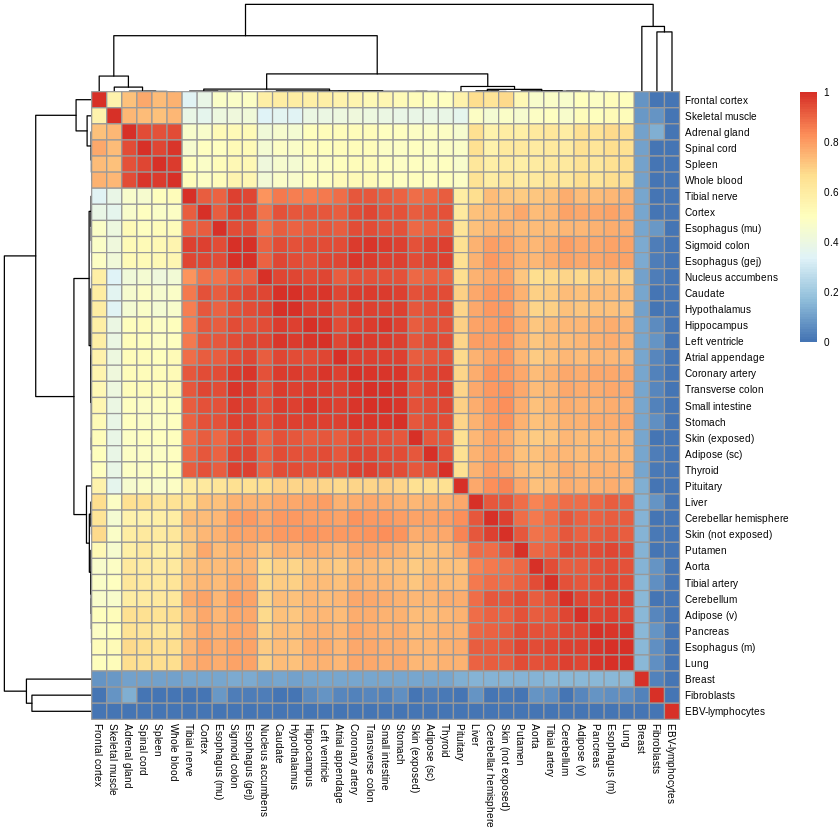

In [16]:
pheatmap(as.matrix(dist.mat.no.NA.NZ), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist.mat.no.NA.NZ, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingDistanceCorrelationHeatmapAlllogFC.pdf"))

### 3.2 heatmap normalize quantiles logFC_mat

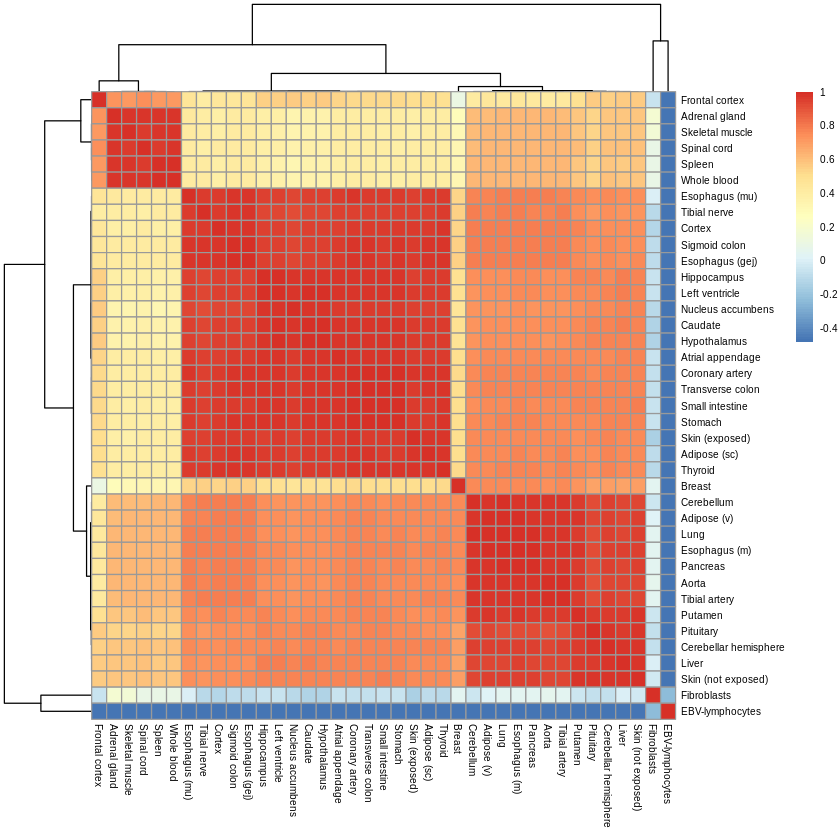

In [17]:
logFC_mat_NQ <- normalizeQuantiles(dist.mat.no.NA.NZ)
dist_mat <- as.matrix(cor(logFC_mat_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingDistanceCorrelationAlllogFC_NQ.pdf"))

### 3.3 heatmap logFC >= 1.5 and adjusted p Value < 0.05

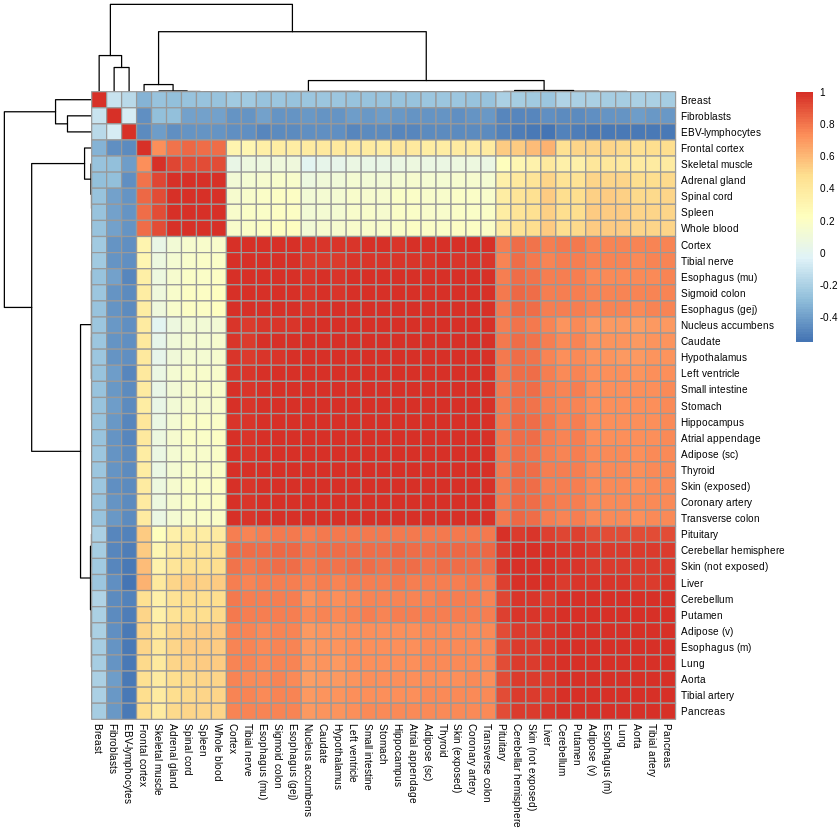

In [18]:
# dist_mat all values with logFC_mat_gt_1.5 
dist_mat <- as.matrix(cor(dist.mat.no.NA.NZ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingDistanceCorrelationHeatmapAlllogFC_gt_1.5.pdf"))

### 3.4 heatmap normalize quantiles logFC >= 1.5 and adjusted pValue < 0.05

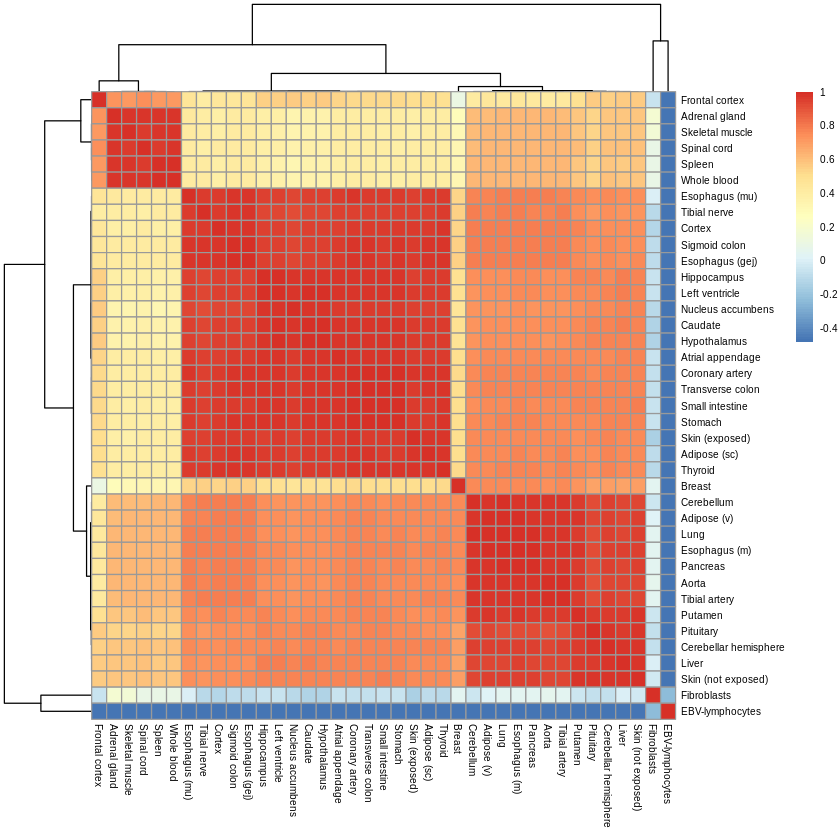

In [19]:
# dist_mat all values with logFC_gt_1.5_mat normalizeQuantiles 
logFC_mat <- normalizeQuantiles(dist.mat.no.NA.NZ)
dist_mat <- as.matrix(cor(logFC_mat))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingCorrelationHeatmapAlllogFC_gt_1.5NQ.pdf"))


In [20]:
# dist_mat all values with logFC_gt_1.5_mat normalizeQuantiles 
logFC_mat_NQ <- normalizeQuantiles(dist.mat.no.NA.NZ)
dist_mat <- as.matrix(cor(logFC_mat_NQ))

In [21]:
desc(dist_mat)

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
Adipose (sc),-1.00000000,-0.75548069,-0.3934510,-0.76160499,-0.97601476,-0.77281806,-0.9634904,-0.76505932,-0.75214755,-0.9620589,⋯,-0.9534350,-0.75967255,-0.74480691,-0.75597185,-0.9730545,-0.96858473,-0.39333674,-0.96988845,-0.9773359,-0.39842225
Adipose (v),-0.75548069,-1.00000000,-0.6140569,-0.97775917,-0.76518513,-0.97865203,-0.7383419,-0.95057719,-0.98486846,-0.7802632,⋯,-0.7729217,-0.98304138,-0.92942231,-0.94684953,-0.7538475,-0.75911933,-0.61727290,-0.75844427,-0.7624133,-0.61841151
Adrenal gland,-0.39345104,-0.61405691,-1.0000000,-0.61760064,-0.40096639,-0.61397345,-0.3595468,-0.57940455,-0.60178211,-0.3885346,⋯,-0.3929970,-0.62139528,-0.53610606,-0.58199908,-0.3917729,-0.39475472,-0.97586594,-0.39983591,-0.3969453,-0.97677114
Aorta,-0.76160499,-0.97775917,-0.6176006,-1.00000000,-0.76488709,-0.98916694,-0.7367587,-0.94000317,-0.97436941,-0.7804989,⋯,-0.7773557,-0.98132784,-0.90974746,-0.93643024,-0.7541460,-0.75776570,-0.61847282,-0.75777687,-0.7610612,-0.61749532
Coronary artery,-0.97601476,-0.76518513,-0.4009664,-0.76488709,-1.00000000,-0.76679456,-0.9783865,-0.77503854,-0.75749693,-0.9677246,⋯,-0.9549651,-0.77009254,-0.76014093,-0.77246923,-0.9729567,-0.99033232,-0.39746430,-0.98909851,-0.9745992,-0.39612952
Tibial artery,-0.77281806,-0.97865203,-0.6139735,-0.98916694,-0.76679456,-1.00000000,-0.7394242,-0.94236910,-0.97736579,-0.7830456,⋯,-0.7791347,-0.97852617,-0.91236895,-0.93840000,-0.7581981,-0.75975446,-0.61755750,-0.75954732,-0.7662715,-0.61993297
Caudate,-0.96349039,-0.73834187,-0.3595468,-0.73675866,-0.97838652,-0.73942416,-1.0000000,-0.77041138,-0.73227718,-0.9532267,⋯,-0.9300955,-0.74350691,-0.76715958,-0.77168013,-0.9641983,-0.97784044,-0.35510525,-0.97466569,-0.9621147,-0.35702961
Cerebellar hemisphere,-0.76505932,-0.95057719,-0.5794045,-0.94000317,-0.77503854,-0.94236910,-0.7704114,-1.00000000,-0.95006553,-0.7439642,⋯,-0.7391401,-0.94171919,-0.97254611,-0.98122001,-0.7663770,-0.77150074,-0.58333274,-0.76536594,-0.7663059,-0.58515353
Cerebellum,-0.75214755,-0.98486846,-0.6017821,-0.97436941,-0.75749693,-0.97736579,-0.7322772,-0.95006553,-1.00000000,-0.7783883,⋯,-0.7851038,-0.98302410,-0.92391375,-0.94009805,-0.7525322,-0.74727979,-0.61721456,-0.74865605,-0.7615765,-0.61724644
Cortex,-0.96205889,-0.78026319,-0.3885346,-0.78049888,-0.96772456,-0.78304561,-0.9532267,-0.74396424,-0.77838827,-1.0000000,⋯,-0.9701381,-0.78685466,-0.73569667,-0.74639122,-0.9584341,-0.96259023,-0.39150079,-0.96558041,-0.9722274,-0.38942279


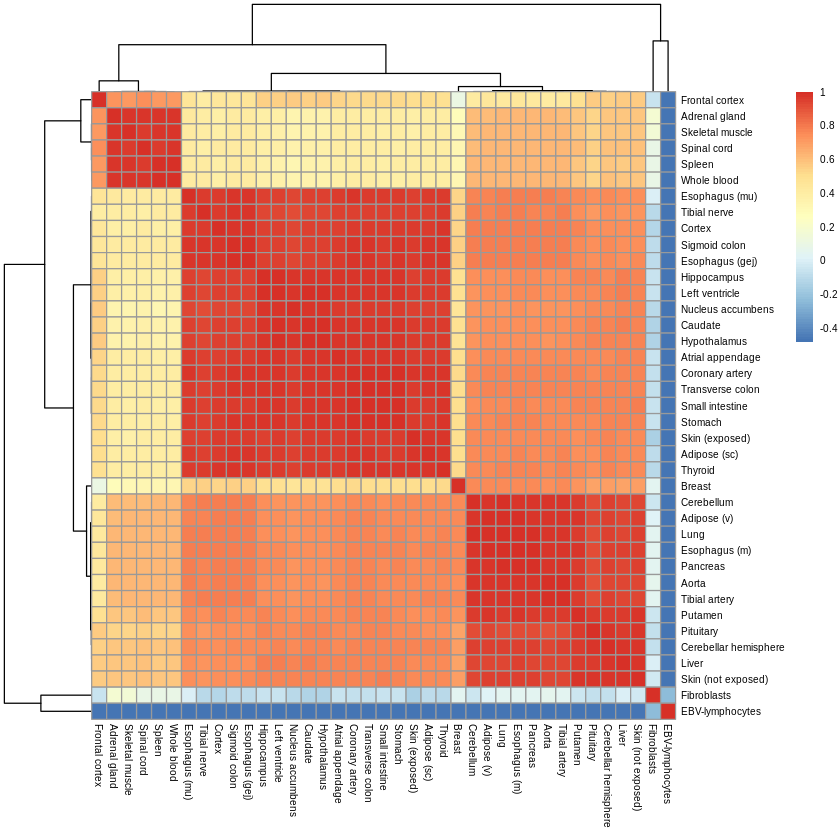

In [22]:
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingCorrelationHeatmapAlllogFC_gt_1.5NQ.pdf"))

### 3.5 save the logFC_mat_gt_1.5_NQ rds object

In [23]:
rownames(dist_mat) <- colnames(logFC_mat)
colnames(dist_mat) <- colnames(logFC_mat)

message("Saving dist_mat object")
saveRDS(object = dist_mat, file = "../data/se_as_dist_mat.rds")
message("Done!")

Saving dist_mat object

Done!



## Appendix Metadata

For replicability and reproducibility purposes, we also print the following metadata:

### Appendix.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [24]:
figure_id   = "alternativeSplicingHeatmap"

### Appendix.2. Libraries

In [25]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..

Done!


Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..

Done!




 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.4 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-08-24                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
circlize,circlize,0.4.10,0.4.10,/opt/conda/lib/R/library/circlize,/opt/conda/lib/R/library/circlize,TRUE,FALSE,2020-06-15,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
ComplexHeatmap,ComplexHeatmap,2.2.0,2.2.0,/opt/conda/lib/R/library/ComplexHeatmap,/opt/conda/lib/R/library/ComplexHeatmap,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
data.table,data.table,1.12.8,1.12.8,/opt/conda/lib/R/library/data.table,/opt/conda/lib/R/library/data.table,TRUE,FALSE,2019-12-09,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
devtools,devtools,2.3.1,2.3.1,/opt/conda/lib/R/library/devtools,/opt/conda/lib/R/library/devtools,TRUE,FALSE,2020-07-21,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
dplyr,dplyr,1.0.2,1.0.2,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-08-18,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.3.2,3.3.2,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2020-06-19,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
magrittr,magrittr,1.5,1.5,/opt/conda/lib/R/library/magrittr,/opt/conda/lib/R/library/magrittr,TRUE,FALSE,2014-11-22,CRAN (R 3.6.0),NA,/opt/conda/lib/R/library
